# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events, compare_ws3_cbm_exactmatch
import pickle

In [2]:
#Start Calculating the Running Time
Start = time.time()

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

## Create and Run `ForestModel` instance

In [4]:
fm = ws3.forest.ForestModel(model_name='redchris',
                            # model_path='./data/woodstock_model_files_redchris',
                            model_path='./data/woodstock_model_files_redchris_test',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

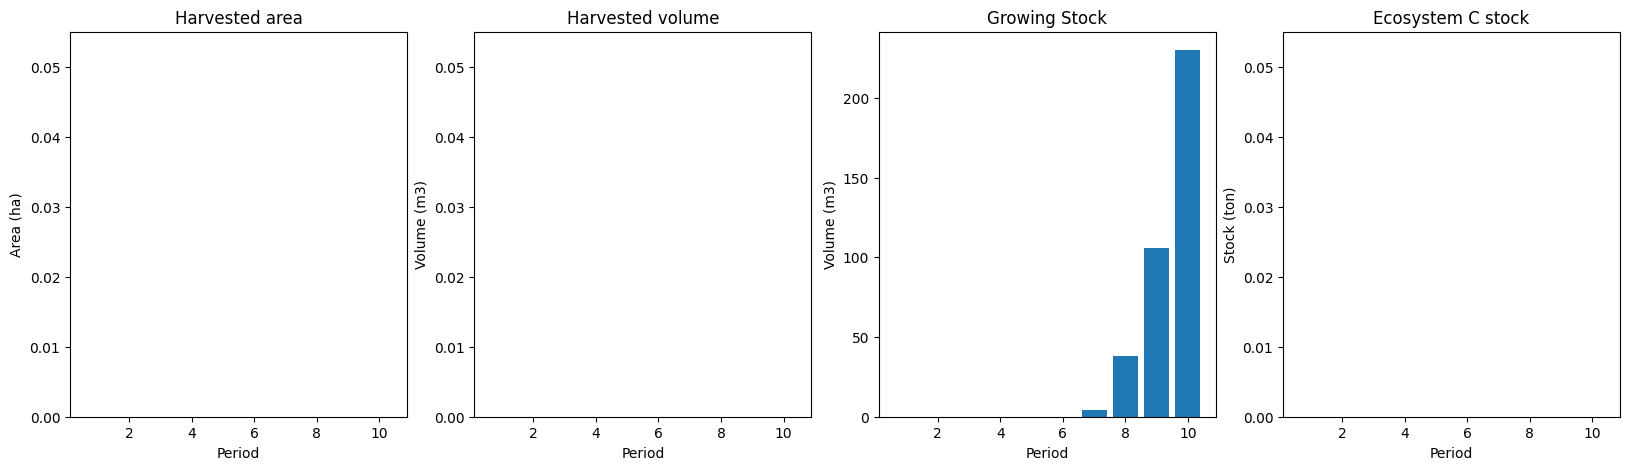

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [8]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator
sit_data = sit_reader.parse(sit_classifiers=sit_tables['sit_classifiers'],
                            sit_disturbance_types=sit_tables['sit_disturbance_types'],
                            sit_age_classes=sit_tables['sit_age_classes'],
                            sit_inventory=sit_tables['sit_inventory'],
                            sit_yield=sit_tables['sit_yield'],
                            sit_events=sit_tables['sit_events'],
                            sit_transitions=sit_tables['sit_transitions'],
                            sit_eligibilities=None)
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)
cbm_output = CBMOutput(classifier_map=sit.classifier_value_names,
                       disturbance_type_map=sit.disturbance_name_map)
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(cbm,
                           n_steps=n_steps,
                           classifiers=classifiers,
                           inventory=inventory,
                           pre_dynamics_func=rule_based_processor.pre_dynamics_func,
                           reporting_func=cbm_output.append_simulation_result,
                           backend_type=BackendType.numpy)
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

In [9]:
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
ecosystem_pools = biomass_pools + dom_pools
# all_pools = biomass_pools + dom_pools + emissions_pools
all_pools = biomass_pools + dom_pools

In [10]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [11]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [12]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,0.003118,1554.875620,1554.878738,0.000000,0.000000,0.000000
1,0.013406,1519.325866,1519.339272,35.550857,0.011391,35.539466
2,0.036787,1486.250763,1486.287549,33.078454,0.026731,33.051723
3,0.078868,1455.272646,1455.351514,30.985838,0.049803,30.936035
4,0.145257,1426.114098,1426.259355,29.173510,0.081351,29.092159
...,...,...,...,...,...,...
96,515.429620,1021.287809,1536.717429,28.280635,38.618803,-10.338168
97,521.632813,1025.307359,1546.940172,28.539369,38.762112,-10.222743
98,527.806056,1029.255576,1557.061632,28.783668,38.905127,-10.121459


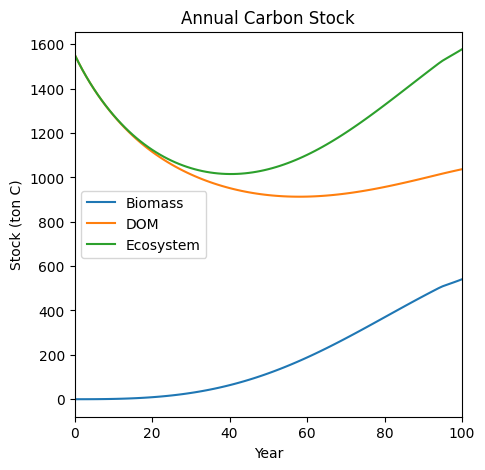

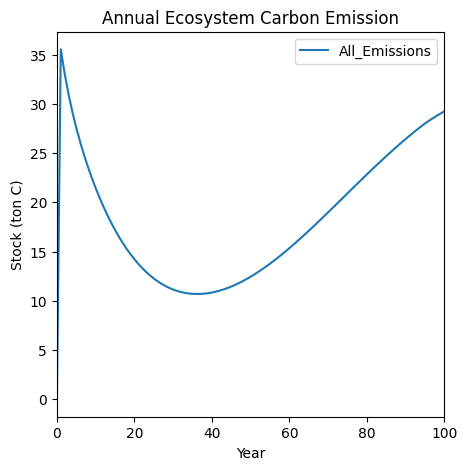

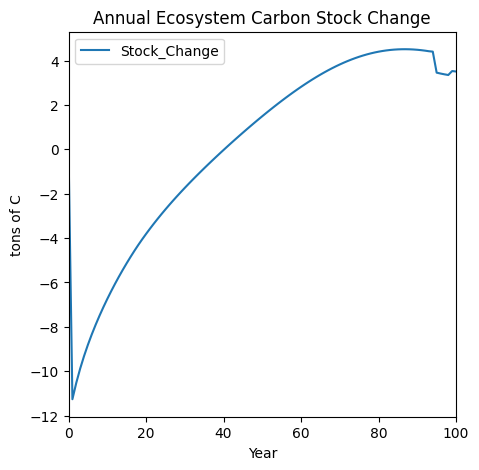

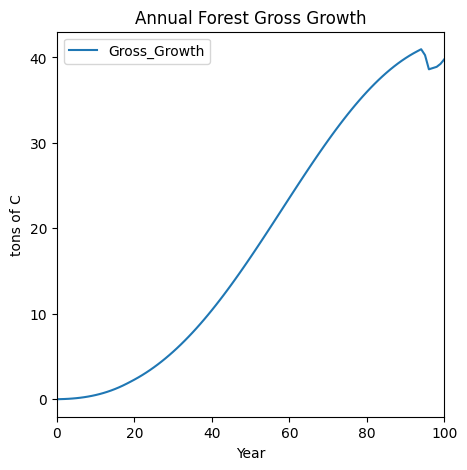

In [13]:
# Report Annual CBM Results
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Generate and Add Carbon Yield Curves

In [14]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [15]:
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire
1,tsa04,1,7,100,7,7,softwood,FALSE,2,5.0,0,0,fire,fire


In [16]:
sit_tables_sit_inventory = sit_tables['sit_inventory'].copy()

In [17]:
# Define Development Type Keys
sit_tables_sit_inventory['dtype_key'] = sit_tables_sit_inventory.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [18]:
sit_tables_sit_inventory

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance,dtype_key
0,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7
1,tsa04,1,7,100,7,7,softwood,FALSE,2,5.0,0,0,fire,fire,tsa04 1 7 100 7 7


In [19]:
timesteps = list(range(101))
sit_tables_sit_inventory_repeated = pd.concat([sit_tables_sit_inventory.assign(timestep=t) for t in timesteps], ignore_index=True)

In [20]:
sit_tables_sit_inventory_repeated

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance,dtype_key,timestep
0,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,0
1,tsa04,1,7,100,7,7,softwood,FALSE,2,5.0,0,0,fire,fire,tsa04 1 7 100 7 7,0
2,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,1
3,tsa04,1,7,100,7,7,softwood,FALSE,2,5.0,0,0,fire,fire,tsa04 1 7 100 7 7,1
4,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,tsa04,1,7,100,7,7,softwood,FALSE,2,5.0,0,0,fire,fire,tsa04 1 7 100 7 7,98
198,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,99
199,tsa04,1,7,100,7,7,softwood,FALSE,2,5.0,0,0,fire,fire,tsa04 1 7 100 7 7,99
200,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,100


In [21]:
sit_tables_sit_inventory_repeated.to_csv('sit_tables_sit_inventory_repeated.csv', index=False)

In [22]:
# Assuming df is your dataframe
# grouped_sit_tables_sit_inventory = sit_tables['sit_inventory'].groupby('dtype_key')['area'].sum().reset_index()

# Rename the columns for clarity (optional)
# grouped_sit_tables_sit_inventory.columns = ['dtype_key', 'total_area']

In [23]:
# grouped_sit_tables_sit_inventory

In [24]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [25]:
# Generate sum carbon pool curves
pi['ecosystem_init'] = pi[ecosystem_pools].sum(axis=1)
pi['biomass_init'] = pi[biomass_pools].sum(axis=1)
pi['DOM_init'] = pi[dom_pools].sum(axis=1)

In [26]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products,dtype_key,ecosystem_init,biomass_init,DOM_init
0,1,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,33183.367009,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1044.677864,0.000624,1044.677240
1,2,0,tsa04,1,7,100,7,7,softwood,5.0,...,0.0,16603.823933,20.864758,187.776906,0.0,0.0,tsa04 1 7 100 7 7,510.200874,0.002494,510.198379
2,1,1,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,33207.647866,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759
3,2,1,tsa04,1,7,100,7,7,softwood,5.0,...,0.0,16615.093933,20.864758,187.776906,0.0,0.0,tsa04 1 7 100 7 7,498.937525,0.008418,498.929107
4,1,2,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,33230.187867,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,997.875050,0.016835,997.858215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,2,98,tsa04,1,7,100,7,7,softwood,5.0,...,0.0,17197.688720,20.864758,187.776906,0.0,0.0,tsa04 1 7 100 7 7,521.256005,177.302877,343.953128
198,1,99,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,34395.377439,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1042.512010,354.605754,687.906256
199,2,99,tsa04,1,7,100,7,7,softwood,5.0,...,0.0,17207.410699,20.864758,187.776906,0.0,0.0,tsa04 1 7 100 7 7,524.788065,179.548573,345.239492
200,1,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,34414.821398,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1049.576130,359.097146,690.478984


In [27]:
pi['age'] = sit_tables_sit_inventory_repeated ['age'].copy()
pi['area'] = sit_tables_sit_inventory_repeated ['area'].copy()

In [28]:
pi['ecosystem'] = pi['ecosystem_init'] / pi['area']
pi['DOM'] = pi['DOM_init'] / pi['area']
pi['biomass'] = pi['biomass_init'] / pi['area']

In [29]:
pi.to_csv('pi.csv', index=False)

In [30]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,Products,dtype_key,ecosystem_init,biomass_init,DOM_init,age,area,ecosystem,DOM,biomass
0,1,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1044.677864,0.000624,1044.677240,1,10.0,104.467786,104.467724,0.000062
1,2,0,tsa04,1,7,100,7,7,softwood,5.0,...,0.0,tsa04 1 7 100 7 7,510.200874,0.002494,510.198379,2,5.0,102.040175,102.039676,0.000499
2,1,1,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759,1,10.0,102.040175,102.039676,0.000499
3,2,1,tsa04,1,7,100,7,7,softwood,5.0,...,0.0,tsa04 1 7 100 7 7,498.937525,0.008418,498.929107,2,5.0,99.787505,99.785821,0.001684
4,1,2,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,997.875050,0.016835,997.858215,1,10.0,99.787505,99.785821,0.001684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,2,98,tsa04,1,7,100,7,7,softwood,5.0,...,0.0,tsa04 1 7 100 7 7,521.256005,177.302877,343.953128,2,5.0,104.251201,68.790626,35.460575
198,1,99,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1042.512010,354.605754,687.906256,1,10.0,104.251201,68.790626,35.460575
199,2,99,tsa04,1,7,100,7,7,softwood,5.0,...,0.0,tsa04 1 7 100 7 7,524.788065,179.548573,345.239492,2,5.0,104.957613,69.047898,35.909715
200,1,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1049.576130,359.097146,690.478984,1,10.0,104.957613,69.047898,35.909715


In [31]:
added_pools = ['ecosystem', 'DOM' , 'biomass' , 'ecosystem_init' , 'DOM_init' , 'biomass_init']
all_pools_md = all_pools + added_pools

In [32]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools_md].sum()
# c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [33]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0          1.053978e-08         0.002551       0.000000   
                  1          1.220945e-07         0.010970       0.000000   
                  2          7.263752e-07         0.030103       0.000000   
                  3          2.905303e-06         0.064537       0.000000   
                  4          8.964910e-06         0.118860       0.000000   
...                                   ...              ...            ...   
                  96         9.960801e+01        56.175159     266.008667   
                  97         1.036842e+02        56.411792     266.772122   
                  98         1.077375e+02        56.652488     267.529817   
                  99         1.119028e+02        56.905033     268.307033   
                  100        1.163131e+02        57.177457     269.128671   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 1 7 100 7 7 0                    0.000325           0.000241   
                  1                    0.001398           0.001037   
                  2                    0.003836           0.002847   
                  3                    0.008225           0.006103   
                  4                    0.015149           0.011240   
...                                         ...                ...   
                  96                  71.265556          22.372231   
                  97                  72.265698          22.499019   
                  98                  73.263086          22.623120   
                  99                  74.290923          22.748570   
                  100                 75.382229          22.879230   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
                  96                  0.0              0.0            0.0   
                  97                  0.0              0.0            0.0   
                  98                  0.0              0.0            0.0   
                  99                  0.0              0.0            0.0   
                  100                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 1 7 100 7 7 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
                  96                        0.0                0.0  ...   
                  97                        0.0                0.0  ...   
                  98                        0.0                0.0  ...   
                  99                        0.0                0.0  ...   
                  100                       0.0                0.0  ...   

                            SoftwoodStemSnag  SoftwoodBranchSnag  \
dtype_key         timestep                                         
t

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [34]:
with open(f'{case_study}_c_curves_p_exactmatch.pkl', 'wb') as file:
    pickle.dump(c_curves_p, file)

In [35]:
# with open(f'{case_study}_c_curves_p_exactmatch.pkl', 'rb') as file:
#     c_curves_p = pickle.load(file)

In [36]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0          1.053978e-08         0.002551       0.000000   
                  1          1.220945e-07         0.010970       0.000000   
                  2          7.263752e-07         0.030103       0.000000   
                  3          2.905303e-06         0.064537       0.000000   
                  4          8.964910e-06         0.118860       0.000000   
...                                   ...              ...            ...   
                  96         9.960801e+01        56.175159     266.008667   
                  97         1.036842e+02        56.411792     266.772122   
                  98         1.077375e+02        56.652488     267.529817   
                  99         1.119028e+02        56.905033     268.307033   
                  100        1.163131e+02        57.177457     269.128671   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 1 7 100 7 7 0                    0.000325           0.000241   
                  1                    0.001398           0.001037   
                  2                    0.003836           0.002847   
                  3                    0.008225           0.006103   
                  4                    0.015149           0.011240   
...                                         ...                ...   
                  96                  71.265556          22.372231   
                  97                  72.265698          22.499019   
                  98                  73.263086          22.623120   
                  99                  74.290923          22.748570   
                  100                 75.382229          22.879230   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
                  96                  0.0              0.0            0.0   
                  97                  0.0              0.0            0.0   
                  98                  0.0              0.0            0.0   
                  99                  0.0              0.0            0.0   
                  100                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 1 7 100 7 7 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
                  96                        0.0                0.0  ...   
                  97                        0.0                0.0  ...   
                  98                        0.0                0.0  ...   
                  99                        0.0                0.0  ...   
                  100                       0.0                0.0  ...   

                            SoftwoodStemSnag  SoftwoodBranchSnag  \
dtype_key         timestep                                         
t

In [37]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])
plugin_c_curves(fm, c_curves_p, pools=sum_pools)

found match for mask ('?', '?', '?', '?', '7', '7')


In [38]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f6edcc94490>),
   ('ecosystem', <ws3.core.Curve at 0x7f6ed6923940>),
   ('biomass', <ws3.core.Curve at 0x7f6ed69235e0>),
   ('DOM', <ws3.core.Curve at 0x7f6ed6922260>)]),
 (('?', '?', '?', '?', '?', '?'),
  'c',
  [('totvol', '_SUM(s0100)'),
   ('swdvol', '_SUM(s0100)'),
   ('hwdvol', '_SUM()')])]

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

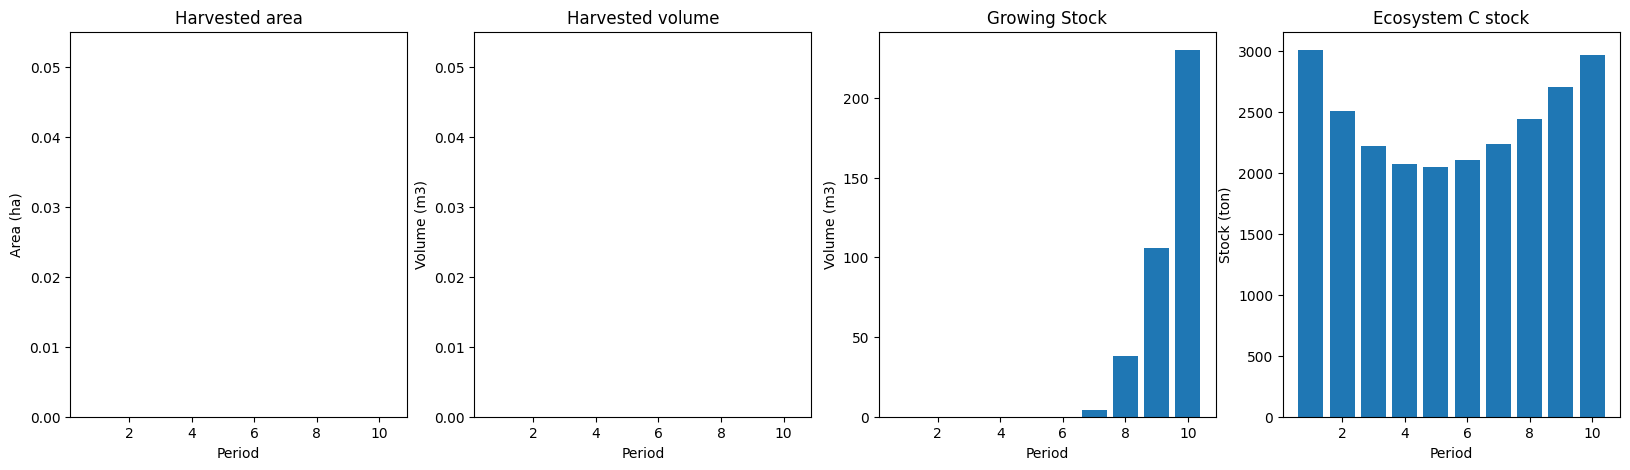

In [39]:
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

In [40]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,0.003118,1554.875620,1554.878738,0.000000,0.000000,0.000000
1,0.013406,1519.325866,1519.339272,35.550857,0.011391,35.539466
2,0.036787,1486.250763,1486.287549,33.078454,0.026731,33.051723
3,0.078868,1455.272646,1455.351514,30.985838,0.049803,30.936035
4,0.145257,1426.114098,1426.259355,29.173510,0.081351,29.092159
...,...,...,...,...,...,...
96,515.429620,1021.287809,1536.717429,28.280635,38.618803,-10.338168
97,521.632813,1025.307359,1546.940172,28.539369,38.762112,-10.222743
98,527.806056,1029.255576,1557.061632,28.783668,38.905127,-10.121459


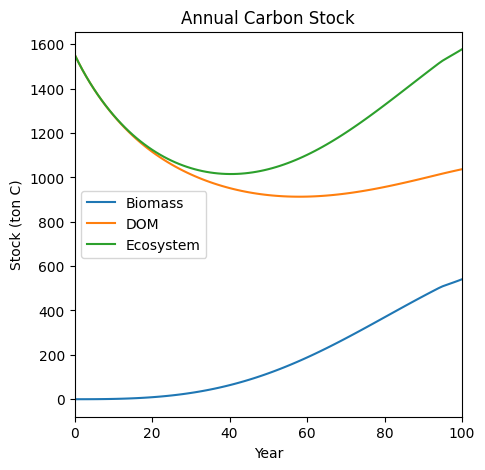

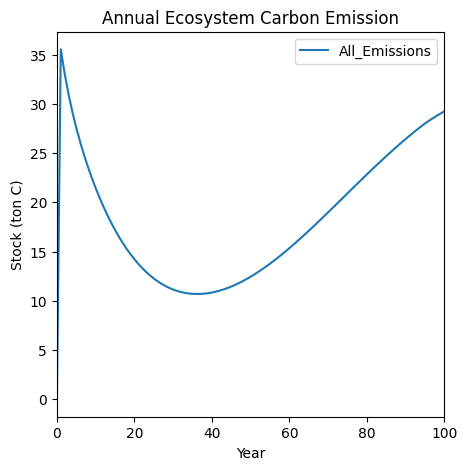

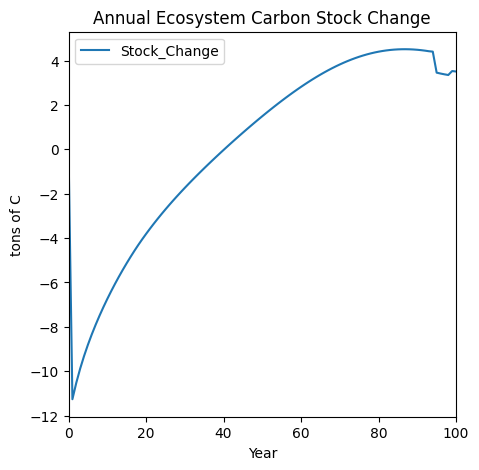

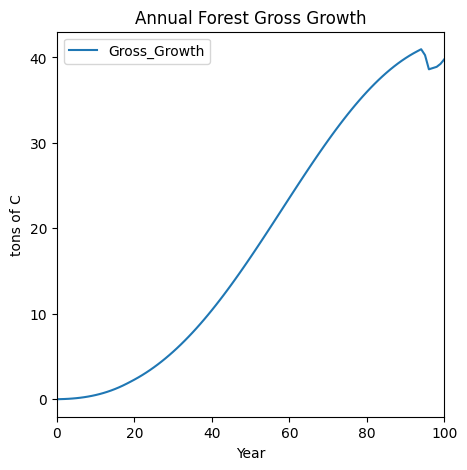

In [41]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

In [46]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm_exactmatch(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="whole")

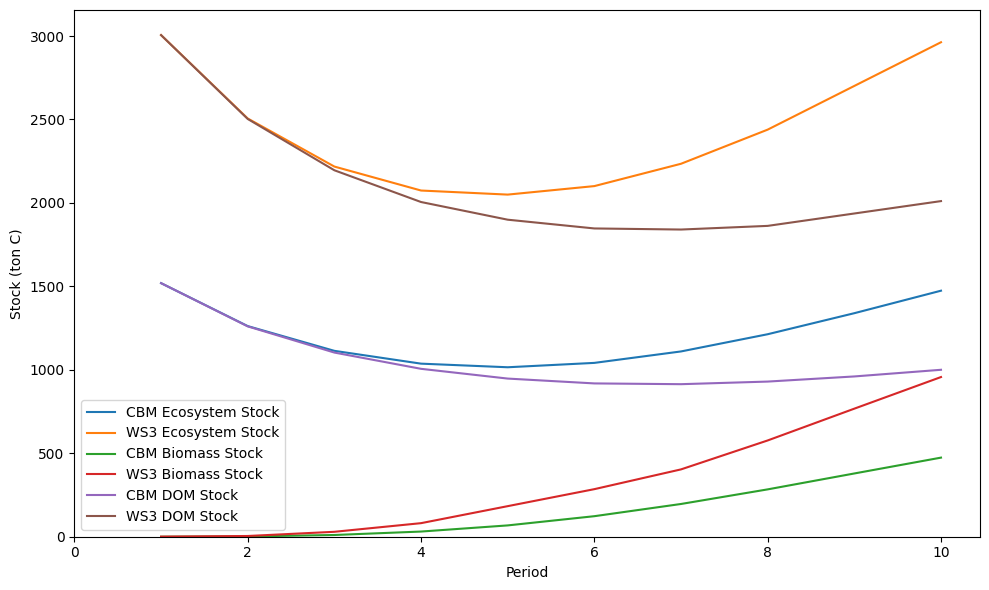

(   period  biomass_stock    dom_stock    eco_stock  eco_stock_change
 0       1       0.013406  1519.325866  1519.339272          0.000000
 1       2       1.760064  1260.240694  1262.000757       -257.338515
 2       3      10.359454  1103.377777  1113.737231       -148.263526
 3       4      30.984760  1005.986155  1036.970915        -76.766317
 4       5      67.786155   947.556258  1015.342414        -21.628501
 5       6     123.016822   918.538127  1041.554948         26.212535
 6       7     196.199338   913.952441  1110.151779         68.596830
 7       8     283.693456   929.575153  1213.268609        103.116831
 8       9     379.000694   960.327657  1339.328350        126.059741
 9      10     473.931139  1000.194331  1474.125470        134.797120,
    period  biomass_stock    dom_stock    eco_stock  eco_stock_change
 0       1       0.520088  3005.576629  3005.626821          0.000000
 1       2       4.357608  2503.041397  2505.837104       -499.789717
 2       3      29.

In [47]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="whole")

In [44]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 0.6 minutes to run this script.
